# Glow Guide

This project is a *skincare* product recommendation system based on the facial problems experienced.
This dataset was scrapped by me from Sephora US with details :

| Feature Name | Description |
| --- | --- |
|**product_href** | Product URL link |
|**product_name** | Product name |
|**product_type** |Type of product |
|**brand** | Product brand |
|**notable_effects** | What it's good for |
|**skin_type** | The suitable type of skin for the product (Normal, Dry, Oily, Combination) |
|**price** | Product price (in USD) |
|**description** | Product description |

# Import Libraries

In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.io as pio
import seaborn as sns
import missingno as mno
from sklearn.feature_extraction.text import TfidfVectorizer

2024-04-16 23:43:58.683717: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/camellia.le1912/Desktop/Skin-Care-Recommender-System/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Data Exploration

In [7]:
skincare = pd.read_csv('processed_data.csv', low_memory=False)
skincare.info()
skincare.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       938 non-null    int64 
 1   product_name     937 non-null    object
 2   product_type     937 non-null    object
 3   brand            937 non-null    object
 4   product_href     937 non-null    object
 5   price            937 non-null    object
 6   notable_effects  554 non-null    object
 7   skin_type        938 non-null    object
 8   Normal           938 non-null    int64 
 9   Oily             938 non-null    int64 
 10  Combination      938 non-null    int64 
 11  Dry              938 non-null    int64 
 12  description      936 non-null    object
dtypes: int64(5), object(8)
memory usage: 95.4+ KB


,Unnamed: 0,product_name,product_type,brand,product_href,price,notable_effects,skin_type,Normal,Oily,Combination,Dry,description
0,0,Lip Butter Balm for Hydration & Shine,Lip Balms & Treatments,Summer Fridays,https://www.sephora.com/product/summer-fridays...,$24.00,Dryness and Dullness,"Normal, Dry, Combination, and Oily",1,1,1,1,A silky vegan balm that hydrates and soothes d...
1,1,Niacinamide 10% + Zinc 1% Oil Control Serum,Face Serums,The Ordinary,https://www.sephora.com/product/the-ordinary-d...,$6.00,Pores and Oiliness,"Normal, Dry, Combination, and Oily",1,1,1,1,A high-strength vitamin-and-mineral blemish fo...
2,2,Dreamy Lip Kit,Value & Gift Sets,LANEIGE,https://www.sephora.com/product/laneige-dreamy...,$20.00,"Dryness, Dullness, and Loss of Firmness and El...","Normal, Dry, Combination, and Oily",1,1,1,1,A kit that features the beloved Lip Sleeping M...
3,3,Watermelon Glow PHA + BHA Pore-Tight Toner,Toners,Glow Recipe,https://www.sephora.com/product/glow-recipe-wa...,$35.00,"Pores, Dryness, and Dullness","Normal, Dry, Combination, and Oily",1,1,1,1,"A bestselling, gentle PHA- and BHA-infused wat..."
4,4,Glycolic Acid 7% Exfoliating Toner,Toners,The Ordinary,https://www.sephora.com/product/the-ordinary-d...,$8.70,Dullness and Uneven Texture,"Normal, Dry, Combination, and Oily",1,1,1,1,A daily surface exfoliator that smooths skin t...


In [8]:
# Check duplicated rows
skincare.duplicated().sum()

0

In [9]:
# Describe the features
cat = ['product_type', 'brand', 'notable_effects', 'skin_type']

skincare[cat].describe()

,product_type,brand,notable_effects,skin_type
count,937,937,554,938
unique,59,151,252,74
top,Face Serums,Supergoop!,Dryness,"Normal, Dry, Combination, and Oily"
freq,121,27,32,733


**SUMMARY**
1. In total, there are 938 products scrapped from websites.  
2. Because this data was scrapped and arranged by me, it looks neater and cleaner. There's no null value.  
3. Fortunately, there are 0 duplicate rows. No needs to be removed.  
4. Of many different types of products, Face Serums is more hype than others.   
5. Supergoop! is the top brand, which means they have many kinds of products.  
6. From many pairs of notable effects, 150 products are good Dryness.
7. Looks like many skin care products suitable for all skin types including Normal, Dry, Combination, Oily.  

## Exploratory Data Analysis (EDA)

In [10]:
counts_brand = skincare['brand'].value_counts()
count_percentage = skincare['brand'].value_counts(1)*100
counts_dfbrand = pd.DataFrame({'Brand':counts_brand.index,'Counts':counts_brand.values,'Percent%':np.round(count_percentage.values,2)})
top_10_brands = counts_dfbrand.head(10)
top_10_brands

,Brand,Counts,Percent%
0,Supergoop!,27,2.88
1,SEPHORA COLLECTION,26,2.77
2,Peter Thomas Roth,25,2.67
3,CLINIQUE,23,2.45
4,Caudalie,23,2.45
5,The Ordinary,23,2.45
6,Tatcha,19,2.03
7,Murad,18,1.92
8,Dr. Dennis Gross Skincare,18,1.92
9,Kiehl's Since 1851,18,1.92


/var/folders/jq/v13lsx0x7hz19q44s7qrfd_00000gn/T/ipykernel_40926/2435786383.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




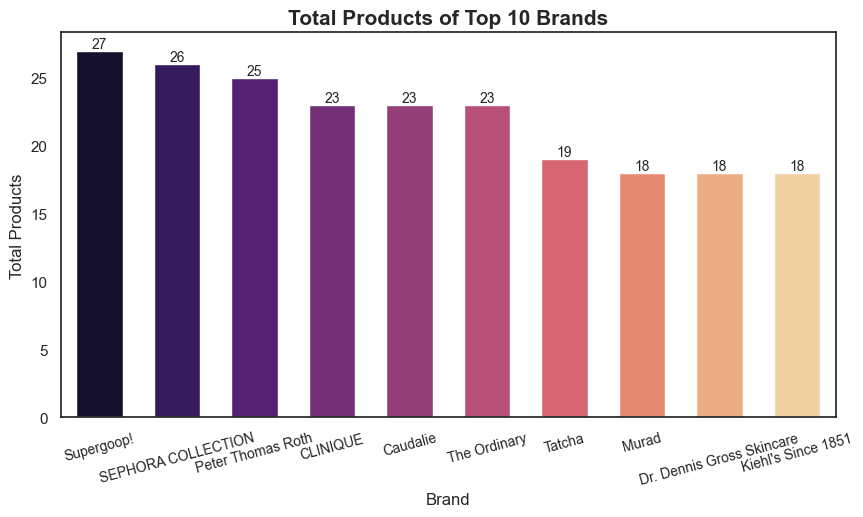

In [11]:
# Brand

plt.figure(figsize=(10, 5))
sns.set(style='white')
ax = sns.barplot(x='Brand', y='Counts', width = 0.6, data=top_10_brands, palette='magma')
ax.set_title('Total Products of Top 10 Brands', fontsize=15, fontweight='bold')
ax.set_xlabel('Brand', fontsize=12, fontweight='medium')
ax.set_ylabel('Total Products', fontsize=12, fontweight='medium')

for label in ax.containers:
    ax.bar_label(label, fontweight='medium', fontsize=10)
plt.xticks(rotation = 15, fontsize=10)
plt.show()

In [12]:
# Checking product type

pd_type = pd.DataFrame()
pd_type["Count"] = skincare["product_type"].value_counts()
pd_type["Count%"] = skincare["product_type"].value_counts()/skincare.shape[0]*100
pd_type

,Count,Count%
product_type,,
Face Serums,121,12.899787
Moisturizers,105,11.194030
Value & Gift Sets,73,7.782516
Eye Creams & Treatments,69,7.356077
Face Wash & Cleansers,53,5.650320
Face Masks,52,5.543710
Lip Balms & Treatments,48,5.117271
Face Sunscreen,47,5.010661
Body Lotions & Body Oils,35,3.731343


In [13]:
fig = px.pie(pd_type, values = 'Count', color = pd_type.index, names = pd_type.index,
             color_discrete_sequence = ['#003049','#D62828', '#F77F00', '#FCBF49', '#E9D8A6'], hole = 0.5)
fig.update_traces(textposition = 'outside', textfont = dict(color = 'dark blue', size = 15), textinfo = 'label+percent', pull = [0.2,0,0,0], rotation = 10)
fig.add_annotation (text = 'Product Type', showarrow = False, font = dict(size = 12, color='dark blue'))
fig.update_layout(title={'text':'Skin Care Product Type', 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'})
fig.show()

In [29]:
# Skin Type That Suitable For the Product
counts = skincare['skin_type'].value_counts()
count_percentage = skincare['skin_type'].value_counts(1)*100
counts_df = pd.DataFrame({'Skin_type':counts.index,'Counts':counts.values,'Percent%':np.round(count_percentage.values,2)})
counts_df = counts_df.sort_values(by='Counts', ascending=False)
print(counts_df.head(5))

                            Skin_type  Counts  Percent%
0  Normal, Dry, Combination, and Oily     733     78.14
1      Normal, Combination, and Oily       37      3.94
2       Normal, Dry, and Combination       19      2.03
3                     Normal and Dry       13      1.39
4               Combination and Oily       11      1.17


In [33]:
# Skin Type
top_5 = counts_df.head(5)
sns.set(style='white')
fig = px.bar(data_frame=top_5, x='Skin_type', y='Counts',
       color='Counts', color_continuous_scale='Inferno_r',
       width=800, height=600,
       text_auto=True, title=f'Count of Skin Type That Suitable For The Product')
fig.update_layout(plot_bgcolor='#FFFCF2', xaxis_tickangle = 15)
fig.show()

In [31]:
# Skin Type
top_7 = counts_df.head(7)
sns.set(style='white')
fig = px.bar(data_frame=top_7, x='Skin_type', y='Counts',
       color='Counts', color_continuous_scale='Inferno_r',
       width=800, height=600,
       text_auto=True, title=f'Count of Skin Type That Suitable For The Product')
fig.update_layout(plot_bgcolor='#FFFCF2', xaxis_tickangle = 15)
fig.show()

In [171]:
# Creating numerical labels of notable_effects due to many effects shown by the diagram above
skincare['notable_effects']=skincare['notable_effects'].astype('category')
skincare['labels']=skincare['notable_effects'].cat.codes
skincare.head()

,Unnamed: 0,product_name,product_type,brand,product_href,price,notable_effects,skin_type,Normal,Oily,Combination,Dry,description,labels
0,0,Lip Butter Balm for Hydration & Shine,Lip Balms & Treatments,Summer Fridays,https://www.sephora.com/product/summer-fridays...,$24.00,Dryness and Dullness,"Normal, Dry, Combination, and Oily",1,1,1,1,A silky vegan balm that hydrates and soothes d...,53
1,1,Niacinamide 10% + Zinc 1% Oil Control Serum,Face Serums,The Ordinary,https://www.sephora.com/product/the-ordinary-d...,$6.00,Pores and Oiliness,"Normal, Dry, Combination, and Oily",1,1,1,1,A high-strength vitamin-and-mineral blemish fo...,197
2,2,Dreamy Lip Kit,Value & Gift Sets,LANEIGE,https://www.sephora.com/product/laneige-dreamy...,$20.00,"Dryness, Dullness, and Loss of Firmness and El...","Normal, Dry, Combination, and Oily",1,1,1,1,A kit that features the beloved Lip Sleeping M...,73
3,3,Watermelon Glow PHA + BHA Pore-Tight Toner,Toners,Glow Recipe,https://www.sephora.com/product/glow-recipe-wa...,$35.00,"Pores, Dryness, and Dullness","Normal, Dry, Combination, and Oily",1,1,1,1,"A bestselling, gentle PHA- and BHA-infused wat...",205
4,4,Glycolic Acid 7% Exfoliating Toner,Toners,The Ordinary,https://www.sephora.com/product/the-ordinary-d...,$8.70,Dullness and Uneven Texture,"Normal, Dry, Combination, and Oily",1,1,1,1,A daily surface exfoliator that smooths skin t...,102


In [182]:
# Skin Type That Suitable For the Product
counts_effect = skincare['notable_effects'].value_counts()
count_percentage = skincare['notable_effects'].value_counts(1)*100
counts_effect_df = pd.DataFrame({'Notable_Effects':counts_effect.index,'Counts':counts_effect.values,'Percent%':np.round(count_percentage.values,2)})
# counts_effect_df.head(10)
print(counts_effect_df)

                                       Notable_Effects  Counts  Percent%
0                                              Dryness      32      5.78
1    Fine Lines and Wrinkles, Dryness, and Loss of ...      26      4.69
2                  Pores, Uneven Texture, and Oiliness      15      2.71
3                Dryness, Dullness, and Uneven Texture      14      2.53
4              Pores, Acne and Blemishes, and Oiliness      13      2.35
..                                                 ...     ...       ...
247  Dullness and Uneven Texture, Dark Spots, and F...       1      0.18
248  Dullness and Uneven Texture, Dark Spots, and P...       1      0.18
249  Dullness and Uneven Texture, Pores, and Drynes...       1      0.18
250              Dullness, Dark Circles, and Puffiness       1      0.18
251                   ryness, Uneven Texture, Oiliness       1      0.18

[252 rows x 3 columns]


In [173]:
top_5 = counts_effect_df.head(5)
fig = px.pie(top_5, values = 'Counts', color = 'Notable_Effects', names = 'Notable_Effects',
             color_discrete_sequence = ['#99582A','#F4ACB7', '#FFCCD5', '#FDFCDC', '#C6AC8F'])
fig.update_traces(textposition = 'inside', textfont = dict(color = 'black', size = 15), textinfo = 'percent')
fig.update_layout(title={'text':'Skin Care Product Notable Effects', 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'})
fig.show()

# Data Preparation

In [174]:
skincare.head(5)

,Unnamed: 0,product_name,product_type,brand,product_href,price,notable_effects,skin_type,Normal,Oily,Combination,Dry,description,labels
0,0,Lip Butter Balm for Hydration & Shine,Lip Balms & Treatments,Summer Fridays,https://www.sephora.com/product/summer-fridays...,$24.00,Dryness and Dullness,"Normal, Dry, Combination, and Oily",1,1,1,1,A silky vegan balm that hydrates and soothes d...,53
1,1,Niacinamide 10% + Zinc 1% Oil Control Serum,Face Serums,The Ordinary,https://www.sephora.com/product/the-ordinary-d...,$6.00,Pores and Oiliness,"Normal, Dry, Combination, and Oily",1,1,1,1,A high-strength vitamin-and-mineral blemish fo...,197
2,2,Dreamy Lip Kit,Value & Gift Sets,LANEIGE,https://www.sephora.com/product/laneige-dreamy...,$20.00,"Dryness, Dullness, and Loss of Firmness and El...","Normal, Dry, Combination, and Oily",1,1,1,1,A kit that features the beloved Lip Sleeping M...,73
3,3,Watermelon Glow PHA + BHA Pore-Tight Toner,Toners,Glow Recipe,https://www.sephora.com/product/glow-recipe-wa...,$35.00,"Pores, Dryness, and Dullness","Normal, Dry, Combination, and Oily",1,1,1,1,"A bestselling, gentle PHA- and BHA-infused wat...",205
4,4,Glycolic Acid 7% Exfoliating Toner,Toners,The Ordinary,https://www.sephora.com/product/the-ordinary-d...,$8.70,Dullness and Uneven Texture,"Normal, Dry, Combination, and Oily",1,1,1,1,A daily surface exfoliator that smooths skin t...,102


# Modelling

### TF-IDF Vectorizer

The TF-IDF Vectorizer will be used in the recommendation system to find a representation of the important features of each notable_effects category. We will use the tfidfvectorizer() function from the sklearn library.

In [175]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming skincare is your DataFrame containing skin care data

# Drop NaN values in the 'notable_effects' column
skincare.dropna(subset=['notable_effects'], inplace=True)

# Initializing TfidfVectorizer
tf = TfidfVectorizer()

# Perform IDF calculation on 'notable_effects' data
tf.fit(skincare['notable_effects'])

# Mapping array from integer index feature to name feature
feature_names = tf.get_feature_names_out()
print(feature_names)


['absorption' 'acne' 'across' 'aids' 'ambitious' 'amp' 'and' 'appearance'
 'applied' 'areas' 'awareour' 'beauty' 'blemishes' 'brands' 'cheekbones'
 'circles' 'clean' 'commitments' 'consumer' 'controversial' 'corporate'
 'curation' 'curved' 'dark' 'dedicated' 'different' 'distinct' 'drainage'
 'dryness' 'dullness' 'edge' 'edges' 'elasticity' 'else' 'environmental'
 'facial' 'features' 'fine' 'fines' 'firmness' 'for' 'from' 'gentle'
 'gently' 'glides' 'gua' 'helps' 'hugs' 'improve' 'in' 'including'
 'ingredients' 'inwardly' 'jawline' 'know' 'like' 'lines' 'loss'
 'lymphatic' 'made' 'making' 'massage' 'meaningful' 'natural' 'nbsp'
 'need' 'of' 'oiliness' 'on' 'outwardly' 'packaging' 'planet' 'pores'
 'pressure' 'products' 'promote' 'promoting' 'provides' 'puffiness'
 'quartz' 'redness' 'reduce' 'reducing' 'relieve' 'rose' 'ryness'
 'scalloped' 'sculpt' 'sha' 'shape' 'skin' 'skincare' 'skintone'
 'sourcing' 'spot' 'spots' 'surface' 'sustainable' 'techniques' 'tension'
 'texture' 'the' 'thr

In [176]:
# Doing fit then transformed to matrix form
tfidf_matrix = tf.fit_transform(skincare['notable_effects'])

# Viewing matrix size TF IDF
shape = tfidf_matrix.shape
shape

(554, 116)

In [177]:
# Convert TF-IDF vector in matrix form with todense() function
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.31413485, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [178]:
# Making dataframe to see TF-IDF matrix

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=skincare.product_name
).sample(shape[1], axis=1).sample(10, axis=0)

,including,for,lines,need,dark,acne,ingredients,tone,helps,jawline,...,promoting,wing,glides,blemishes,of,scalloped,planet,edges,beauty,elasticity
product_name,,,,,,,,,,,,,,,,,,,,,
Mini Water Drench ® Hyaluronic Hydrating Moisturizer SPF 45,0.0,0.0,0.488330,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000
Rose Face Mask,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000
Floral Recovery Overnight Mask with Squalane,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000
Salicylic Acid Acne + Blackhead Cleanser,0.0,0.0,0.000000,0.0,0.0,0.529138,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.516281,0.00000,0.0,0.0,0.0,0.0,0.000000
The Micro Peel,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000
Mini Moisture Surge™ Broad Spectrum SPF 28 Sheer Hydrator Moisturizer,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000
Plump + Hydrate Duo,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.41307,0.0,0.0,0.0,0.0,0.411767
High Performance Face Serum with Vitamin C and Hyaluronic Acid \t\t\t\t\t\t,0.0,0.0,0.266884,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.35004,0.0,0.0,0.0,0.0,0.348935
Blur + Smooth Duo,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000


### Cosine Similarity

In [179]:
# Calculating Cosine Similarity on the TF-IDF matrix
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.11085686, 0.5388721 , ..., 0.60986946, 0.39928888,
        0.70229882],
       [0.11085686, 1.        , 0.10275812, ..., 0.15303245, 0.08159412,
        0.07785465],
       [0.5388721 , 0.10275812, 1.        , ..., 0.38674348, 0.24055602,
        0.37844924],
       ...,
       [0.60986946, 0.15303245, 0.38674348, ..., 1.        , 0.2939309 ,
        0.76035342],
       [0.39928888, 0.08159412, 0.24055602, ..., 0.2939309 , 1.        ,
        0.28042011],
       [0.70229882, 0.07785465, 0.37844924, ..., 0.76035342, 0.28042011,
        1.        ]])

In [180]:
# Creating a dataframe from the cosine_similarity variable with rows and columns in the form of product names
cosine_sim_df = pd.DataFrame(cosine_sim, index=skincare['product_name'], columns=skincare['product_name'])

# See the similarity matrix for each product
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

product_name,Superfood Hydrating and Nourishing Facial Oil,Moisturizing Fig Body Oil Elixir,Pink Cloud Soft Moisture Cream,barrier+ Triple Lipid-Boost 360° Hydrating Eye Cream,All About Clean™ 2-in-1 Charcoal Face Mask + Scrub
product_name,,,,,
Brightening Active Roller with Vitamin C,0.181345,0.079369,0.230485,0.237817,0.045587
Clean Conscious Body Sunscreen Mist with Vitamin C SPF 30-50,0.662970,0.698163,0.508222,0.339843,0.116788
Enzyme Cleansing Gel,0.213874,0.093606,0.271828,0.075544,0.800001
Glowscreen Body Lotion SPF 40,0.378449,0.241716,0.480999,0.090009,0.468640
Pro-Collagen Naked Makeup Melting Cleansing Balm,0.355059,0.226776,0.451270,0.084446,0.060100
Liquid ExfoliKate® Triple Acid Resurfacing Treatment,0.140568,0.061522,0.178658,0.049651,0.423682
Super Anti-Aging Night Cream,0.828337,0.872309,0.640018,0.368861,0.108123
Vinoperfect Brightening Glycolic Peel Mask,0.187938,0.082254,0.238864,0.246463,0.345630
Volcanic BHA Pore Cleansing Foam,0.084550,0.089038,0.107460,0.071858,1.000000


### Getting Recommendation

In [181]:
def skincare_recommendations(nama, similarity_data=cosine_sim_df, items=skincare[['product_name', 'notable_effects']], k=5):

    # Retrieve data by using argpartition to partition indirectly along a given axis
    # Dataframe converted to be numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama].to_numpy().argpartition(
        range(-1, -k, -1))

    # Retrieve data with the greatest similarity from the existing index
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop a name so that the name of the product we are looking for doesnt' appear in the list of recommendations
    closest = closest.drop(nama, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)